# Extracting Renewables.ninja Data via API

# Inhaltsverzeichnis

1. [PV Fetch-Test-Single-Region](#01-Fetch-Test-Single-Region)
2. [PV-Fetch-Masterarbeit](#02-PV-Fetch-Masterarbeit)
3. [Wind-Fetch-Masterarbeit](#03-Wind-Fetch-Masterarbeit)
4. [PV-Fetch-H2-Map](#04-PV-Fetch-H2-Map)
5. [Wind-Fetch-H2-Map](#05-Wind-Fetch-H2-Map)


In [34]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.dates as mdates
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta
import requests
import pandas as pd
import json
import time

<a id="01-Fetch-Test-Single-Region"></a>
#### 0.1 PV Fetch-Test-Single-Region

In [32]:
path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\Ninja Data\zentroiden_buses.xlsx"
buses_lat_lon = pd.read_excel(path)
print(buses_lat_lon)
for index, row in buses_lat_lon.iterrows():
    lat = row['lat']  # Stelle sicher, dass die Spaltennamen korrekt sind
    lon = row['lon']
# pv params: 
pv_params = {
        'lat': lat,
        'lon': lon,
        'date_from': f'{2019}-01-01',
        'date_to': f'{2019}-12-31',
        'dataset': 'merra2',
        'capacity': 1.0,
        'loss_fraction': 0.1,
        'tracking': None,
        'tilt': 32, # optimaler Winkel KAZ
        'azimuth': 180, # optimaler Winkel KAZ
        'format': 'json'
        }

              Region      lat      lon
0             Akmola  51.7842  69.9087
1          Karaganda  48.2237  70.9946
2            Zhambyl  44.3174  72.1398
3    East Kazakhstan  48.7983  81.4942
4             Almaty  44.9750  77.9258
5   South Kazakhstan  43.2184  68.4528
6             Aktobe  48.6041  58.5964
7             Atyrau  47.5224  52.1174
8          Kyzylorda  45.1934  63.6335
9           Kostanay  51.6018  64.0173
10         Mangystau  44.1015  53.9825
11  North Kazakhstan  53.8564  69.2661
12          Pavlodar  52.0707  76.2425
13   West Kazakhstan  49.8097  50.6728


# Start: Nur eine Region abfragen und JSON Output genauer untersuchen:

In [47]:
import pandas as pd
import requests
import json

def fetch_single_region_pv_data_and_save(path, year, api_key):
    # Lade die Koordinaten aus der Excel-Datei
    buses_lat_lon = pd.read_excel(path)
    
    # Hole die Daten nur für die erste Region
    first_region = buses_lat_lon.iloc[0]
    lat = first_region['lat']
    lon = first_region['lon']
    region = first_region['Region']

    # Daten für PV abrufen
    print(f"Fetching PV data for {region} (lat: {lat}, lon: {lon})")
    pv_data = fetch_single_ninja_data(lat, lon, 'pv', year, api_key)
    
    if pv_data:
        # Speichern der Rohdaten als JSON-Datei
        with open(f'{region}_pv_raw.json', 'w') as outfile:
            json.dump(pv_data, outfile, indent=4)
        print(f"Raw PV data for {region} successfully saved as JSON.")
    else:
        print(f"Error fetching PV data for {region} (lat: {lat}, lon: {lon})")

def fetch_single_ninja_data(lat, lon, tech, year, api_key):
    url = f"https://www.renewables.ninja/api/data/{tech}"
    params = {
        'lat': lat,
        'lon': lon,
        'date_from': f'{year}-01-01',
        'date_to': f'{year}-12-31',
        'dataset': 'merra2',
        'capacity': 1.0,
        'system_loss': 0.1,
        'tracking': 0,
        'tilt': 32,
        'azim': 180,
        'format': 'json'
    }
    headers = {'Authorization': f'Token {api_key}'}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()  # Rückgabe der Rohdaten
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Beispielaufruf der Funktion
path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\Ninja Data\zentroiden_buses.xlsx"
year = 2019
api_key = 'ddd5c93db5b857fe1d3257ac2e849f8858aac36c'

#fetch_single_region_pv_data_and_save(path, year, api_key)

Fetching PV data for Akmola (lat: 51.7842, lon: 69.9087)
Raw PV data for Akmola successfully saved as JSON.


In [52]:
import json
import pandas as pd
from datetime import datetime

# Load the raw JSON data
def load_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data

# Process the data into a DataFrame and convert to local time
def process_region_data(json_data, region_name):
    timestamps = []
    electricity_values = []
    
    # Extract the data
    for ts, values in json_data['data'].items():
        # Convert Unix timestamp (milliseconds) to UTC time
        timestamp = pd.to_datetime(int(ts), unit='ms', utc=True)
        timestamps.append(timestamp)
        electricity_values.append(values['electricity'])
    
    # Create DataFrame with time as index and electricity as the value
    region_df = pd.DataFrame({
        'time': timestamps,
        region_name: electricity_values
    })
    
    # Set time as index
    region_df.set_index('time', inplace=True)
    
    # Convert UTC to local time (Asia/Almaty)
    region_df.index = region_df.index.tz_convert('Asia/Almaty')
    
    # Remove timezone information (localize to None)
    region_df.index = region_df.index.tz_localize(None)
    
    return region_df

# Combine data from multiple regions into a single DataFrame
def combine_region_data(region_dataframes):
    combined_df = pd.concat(region_dataframes, axis=1)
    return combined_df

# Save the combined data as an Excel file
def save_to_excel(df, output_file):
    df.to_excel(output_file)

# Main function to load, process, and combine data for multiple regions
def main(json_files, region_names, output_file):
    region_dataframes = []
    
    for json_file, region_name in zip(json_files, region_names):
        json_data = load_json_file(json_file)
        region_df = process_region_data(json_data, region_name)
        region_dataframes.append(region_df)
    
    # Combine the region DataFrames
    combined_df = combine_region_data(region_dataframes)
    
    # Save the result to an Excel file
    save_to_excel(combined_df, output_file)
    print(f"Data successfully saved to {output_file}")

# Example usage
json_files = ['Akmola_pv_raw.json']  # Add paths to other region JSON files as needed
region_names = ['Akmola']  # Corresponding region names
output_file = 'combined_pv_data_local_time.xlsx'

# Process and save the data
#main(json_files, region_names, output_file)


Data successfully saved to combined_pv_data_local_time.xlsx


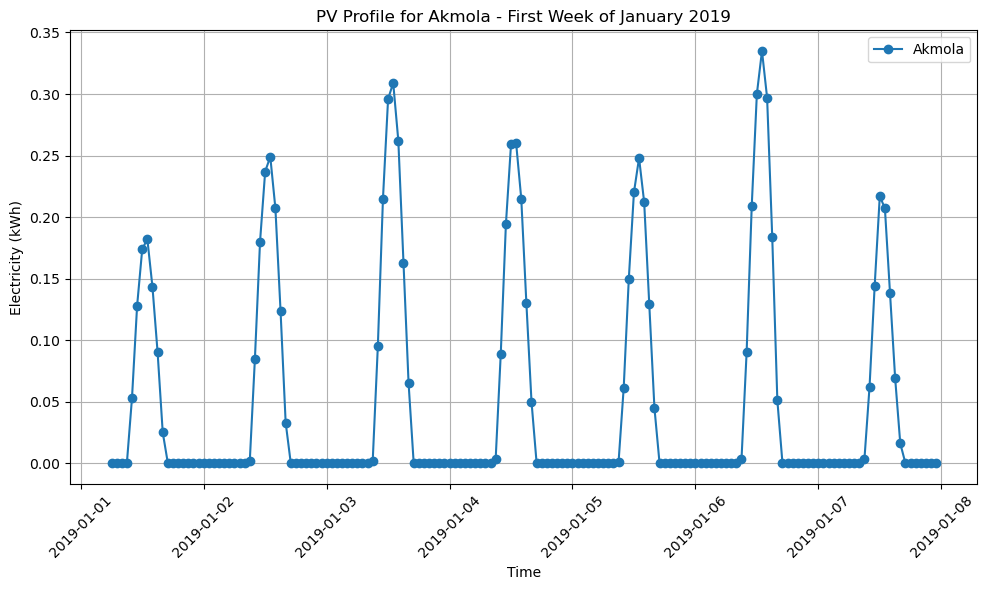

In [56]:
# Lade die Daten
check_data = pd.read_excel('combined_pv_data_local_time.xlsx')

# Konvertiere die 'time'-Spalte zu einem Datetime-Objekt, falls sie noch nicht konvertiert wurde
check_data['time'] = pd.to_datetime(check_data['time'])

# Setze 'time' als Index für die einfache Auswahl
check_data.set_index('time', inplace=True)

# Filtere die erste Woche
first_week_data = check_data.loc['2019-01-01':'2019-01-07']

# Plotten der Daten
plt.figure(figsize=(10, 6))
plt.plot(first_week_data.index, first_week_data['Akmola'], label='Akmola', marker='o')
plt.title('PV Profile for Akmola - First Week of January 2019')
plt.xlabel('Time')
plt.ylabel('Electricity (kWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

<a id="02-PV-Fetch-Masterarbeit"></a>
#### 0.2 PV-Fetch-Masterarbeit

In [57]:
# Okay and now fetch for the whole PV Dataset:
def fetch_single_region_pv_data_and_save(path, year, api_key, save_dir):
    # Lade die Koordinaten aus der Excel-Datei
    buses_lat_lon = pd.read_excel(path)
    
    # Iteriere über alle Regionen in der Excel-Datei
    for index, row in buses_lat_lon.iterrows():
        lat = row['lat']
        lon = row['lon']
        region = row['Region']

        # Daten für PV abrufen
        print(f"Fetching PV data for {region} (lat: {lat}, lon: {lon})")
        pv_data = fetch_single_ninja_data(lat, lon, 'pv', year, api_key)
        
        if pv_data:
            # Erstelle den vollständigen Pfad für das JSON-Datei
            json_file_path = os.path.join(save_dir, f'{region}_pv_raw.json')
            
            # Speichern der Rohdaten als JSON-Datei
            with open(json_file_path, 'w') as outfile:
                json.dump(pv_data, outfile, indent=4)
            print(f"Raw PV data for {region} successfully saved as JSON.")
        else:
            print(f"Error fetching PV data for {region} (lat: {lat}, lon: {lon})")

# Fetch PV data from Renewables Ninja
def fetch_single_ninja_data(lat, lon, tech, year, api_key):
    url = f"https://www.renewables.ninja/api/data/{tech}"
    params = {
        'lat': lat,
        'lon': lon,
        'date_from': f'{year}-01-01',
        'date_to': f'{year}-12-31',
        'dataset': 'merra2',
        'capacity': 1.0,
        'system_loss': 0.1,
        'tracking': 0,
        'tilt': 32,
        'azim': 180,
        'format': 'json'
    }
    headers = {'Authorization': f'Token {api_key}'}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()  # Rückgabe der Rohdaten
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Process the data into a DataFrame and convert to local time
def process_region_data(json_data, region_name):
    timestamps = []
    electricity_values = []
    
    # Extract the data
    for ts, values in json_data['data'].items():
        # Convert Unix timestamp (milliseconds) to UTC time
        timestamp = pd.to_datetime(int(ts), unit='ms', utc=True)
        timestamps.append(timestamp)
        electricity_values.append(values['electricity'])
    
    # Create DataFrame with time as index and electricity as the value
    region_df = pd.DataFrame({
        'time': timestamps,
        region_name: electricity_values
    })
    
    # Set time as index
    region_df.set_index('time', inplace=True)
    
    # Convert UTC to local time (Asia/Almaty)
    region_df.index = region_df.index.tz_convert('Asia/Almaty')
    
    # Remove timezone information (localize to None)
    region_df.index = region_df.index.tz_localize(None)
    
    return region_df

# Combine data from multiple regions into a single DataFrame
def combine_region_data(region_dataframes):
    combined_df = pd.concat(region_dataframes, axis=1)
    return combined_df

# Save the combined data as an Excel file
def save_to_excel(df, output_file):
    df.to_excel(output_file)

# Main function to load, process, and combine data for multiple regions
def process_and_save_data(json_files, region_names, output_file):
    region_dataframes = []
    
    for json_file, region_name in zip(json_files, region_names):
        json_data = load_json_file(json_file)
        region_df = process_region_data(json_data, region_name)
        region_dataframes.append(region_df)
    
    # Combine the region DataFrames
    combined_df = combine_region_data(region_dataframes)
    
    # Save the result to an Excel file
    save_to_excel(combined_df, output_file)
    print(f"Data successfully saved to {output_file}")

# Load the raw JSON data
def load_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data

# Example usage for fetching and saving JSON data for all regions
path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\Ninja Data\zentroiden_buses.xlsx"
year = 2019
api_key = 'ddd5c93db5b857fe1d3257ac2e849f8858aac36c'
save_dir = r'C:\Users\jan.carsten\Python Programmieren\Renewables_ninja_API_JSON_data'

# Fetch data for all regions and save as JSON
#fetch_single_region_pv_data_and_save(path, year, api_key, save_dir)

# Beispiel für die Verarbeitung der JSON-Dateien und das Speichern der kombinierten Excel-Datei
json_files = [os.path.join(save_dir, f'{region}_pv_raw.json') for region in buses_lat_lon['Region']]  # Für alle Regionen
region_names = buses_lat_lon['Region'].tolist()  # Entsprechend alle Regionsnamen
output_file = r'C:\Users\jan.carsten\Python Programmieren\Renewables_ninja_API_JSON_data\combined_pv_data_local_time.xlsx'

# Prozessieren und Speichern der Daten in Excel
#process_and_save_data(json_files, region_names, output_file)

Fetching PV data for Akmola (lat: 51.7842, lon: 69.9087)
Raw PV data for Akmola successfully saved as JSON.
Fetching PV data for Karaganda (lat: 48.2237, lon: 70.9946)
Raw PV data for Karaganda successfully saved as JSON.
Fetching PV data for Zhambyl (lat: 44.3174, lon: 72.1398)
Raw PV data for Zhambyl successfully saved as JSON.
Fetching PV data for East Kazakhstan (lat: 48.7983, lon: 81.4942)
Raw PV data for East Kazakhstan successfully saved as JSON.
Fetching PV data for Almaty (lat: 44.975, lon: 77.9258)
Raw PV data for Almaty successfully saved as JSON.
Fetching PV data for South Kazakhstan (lat: 43.2184, lon: 68.4528)
Raw PV data for South Kazakhstan successfully saved as JSON.
Fetching PV data for Aktobe (lat: 48.6041, lon: 58.5964)
Raw PV data for Aktobe successfully saved as JSON.
Fetching PV data for Atyrau (lat: 47.5224, lon: 52.1174)
Raw PV data for Atyrau successfully saved as JSON.
Fetching PV data for Kyzylorda (lat: 45.1934, lon: 63.6335)
Raw PV data for Kyzylorda succe

<a id="03-Wind-Fetch-Masterarbeit"></a>
#### 0.3 Wind-Fetch-Masterarbeit

In [63]:
import os
import pandas as pd
import requests
import json

# Fetch wind data for a single region and save as JSON
def fetch_single_region_wind_data_and_save(path, year, api_key, save_dir):
    # Lade die Koordinaten aus der Excel-Datei
    buses_lat_lon = pd.read_excel(path)
    
    # Iteriere über alle Regionen in der Excel-Datei
    for index, row in buses_lat_lon.iterrows():
        lat = row['lat']
        lon = row['lon']
        region = row['Region']

        # Daten für Wind abrufen
        print(f"Fetching Wind data for {region} (lat: {lat}, lon: {lon})")
        wind_data = fetch_single_ninja_data(lat, lon, 'wind', year, api_key)
        
        if wind_data:
            # Erstelle den vollständigen Pfad für die JSON-Datei
            json_file_path = os.path.join(save_dir, f'{region}_wind_raw.json')
            
            # Speichern der Rohdaten als JSON-Datei
            with open(json_file_path, 'w') as outfile:
                json.dump(wind_data, outfile, indent=4)
            print(f"Raw Wind data for {region} successfully saved as JSON.")
        else:
            print(f"Error fetching Wind data for {region} (lat: {lat}, lon: {lon})")
        
        # Warte 1,2 Sekunden, um das Burst-Limit nicht zu überschreiten
        time.sleep(1.2)

# Fetch Wind data from Renewables Ninja
def fetch_single_ninja_data(lat, lon, tech, year, api_key):
    url = f"https://www.renewables.ninja/api/data/{tech}"
    params = {
        'lat': lat,
        'lon': lon,
        'date_from': f'{year}-01-01',
        'date_to': f'{year}-12-31',
        'dataset': 'merra2',
        'capacity': 1.0,
        'height': 90,  # Hub height of the wind turbine
        'turbine': 'Goldwind GW121 2500',  # Goldwind GW121/2500 model
        'format': 'json'
    }
    headers = {'Authorization': f'Token {api_key}'}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()  # Rückgabe der Rohdaten
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Process the data into a DataFrame and convert to local time
def process_region_data(json_data, region_name):
    timestamps = []
    electricity_values = []
    
    # Extract the data
    for ts, values in json_data['data'].items():
        # Convert Unix timestamp (milliseconds) to UTC time
        timestamp = pd.to_datetime(int(ts), unit='ms', utc=True)
        timestamps.append(timestamp)
        electricity_values.append(values['electricity'])
    
    # Create DataFrame with time as index and electricity as the value
    region_df = pd.DataFrame({
        'time': timestamps,
        region_name: electricity_values
    })
    
    # Set time as index
    region_df.set_index('time', inplace=True)
    
    # Convert UTC to local time (Asia/Almaty)
    region_df.index = region_df.index.tz_convert('Asia/Almaty')
    
    # Remove timezone information (localize to None)
    region_df.index = region_df.index.tz_localize(None)
    
    return region_df

# Combine data from multiple regions into a single DataFrame
def combine_region_data(region_dataframes):
    combined_df = pd.concat(region_dataframes, axis=1)
    return combined_df

# Save the combined data as an Excel file
def save_to_excel(df, output_file):
    df.to_excel(output_file)

# Main function to load, process, and combine data for multiple regions
def process_and_save_data(json_files, region_names, output_file):
    region_dataframes = []
    
    for json_file, region_name in zip(json_files, region_names):
        json_data = load_json_file(json_file)
        region_df = process_region_data(json_data, region_name)
        region_dataframes.append(region_df)
    
    # Combine the region DataFrames
    combined_df = combine_region_data(region_dataframes)
    
    # Save the result to an Excel file
    save_to_excel(combined_df, output_file)
    print(f"Data successfully saved to {output_file}")

# Load the raw JSON data
def load_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data

# Example usage for fetching and saving JSON data for all regions
path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\Ninja Data\zentroiden_buses.xlsx"
year = 2019
api_key = 'ddd5c93db5b857fe1d3257ac2e849f8858aac36c'
save_dir = r'C:\Users\jan.carsten\Python Programmieren\Renewables_ninja_API_JSON_data'

# Fetch wind data for all regions and save as JSON
fetch_single_region_wind_data_and_save(path, year, api_key, save_dir)

# Beispiel für die Verarbeitung der JSON-Dateien und das Speichern der kombinierten Excel-Datei
json_files = [os.path.join(save_dir, f'{region}_wind_raw.json') for region in buses_lat_lon['Region']]  # Für alle Regionen
region_names = buses_lat_lon['Region'].tolist()  # Entsprechend alle Regionsnamen
output_file = r'C:\Users\jan.carsten\Python Programmieren\Renewables_ninja_API_JSON_data\combined_wind_data_local_time.xlsx'

# Prozessieren und Speichern der Daten in Excel
#process_and_save_data(json_files, region_names, output_file)

Fetching Wind data for Akmola (lat: 51.7842, lon: 69.9087)
Raw Wind data for Akmola successfully saved as JSON.
Fetching Wind data for Karaganda (lat: 48.2237, lon: 70.9946)
Raw Wind data for Karaganda successfully saved as JSON.
Fetching Wind data for Zhambyl (lat: 44.3174, lon: 72.1398)
Raw Wind data for Zhambyl successfully saved as JSON.
Fetching Wind data for East Kazakhstan (lat: 48.7983, lon: 81.4942)
Raw Wind data for East Kazakhstan successfully saved as JSON.
Fetching Wind data for Almaty (lat: 44.975, lon: 77.9258)
Raw Wind data for Almaty successfully saved as JSON.
Fetching Wind data for South Kazakhstan (lat: 43.2184, lon: 68.4528)
Raw Wind data for South Kazakhstan successfully saved as JSON.
Fetching Wind data for Aktobe (lat: 48.6041, lon: 58.5964)
Raw Wind data for Aktobe successfully saved as JSON.
Fetching Wind data for Atyrau (lat: 47.5224, lon: 52.1174)
Raw Wind data for Atyrau successfully saved as JSON.
Fetching Wind data for Kyzylorda (lat: 45.1934, lon: 63.633

In [65]:
# Funktion zur Berechnung der durchschnittlichen Verfügbarkeit über alle Regionen und alle Zeitschritte
def calculate_average_availability(excel_file):
    # Lade die Excel-Datei
    data = pd.read_excel(excel_file, index_col=0)
    
    # Berechne den Durchschnitt über alle Zeitschritte für jede Region (Spalte)
    region_averages = data.mean(axis=0)
    
    # Berechne den Gesamtdurchschnitt über alle Regionen und Zeitschritte
    overall_average = region_averages.mean()
    
    # Finde die Region(en) mit dem höchsten Durchschnittswert
    max_avg_value = region_averages.max()
    max_regions = region_averages[region_averages == max_avg_value].index.tolist()
    
    return overall_average, max_regions, max_avg_value

# Beispiel für die PV-Daten
pv_excel_file = r'C:\Users\jan.carsten\Python Programmieren\Renewables_ninja_API_JSON_data\combined_pv_data_local_time.xlsx'
pv_overall_avg, pv_max_regions, pv_max_value = calculate_average_availability(pv_excel_file)
print(f"Durchschnittliche PV-Verfügbarkeit über alle Regionen und Zeitschritte: {pv_overall_avg}")
print(f"Region(en) mit der höchsten PV-Verfügbarkeit: {pv_max_regions} mit einem Durchschnitt von {pv_max_value}")

# Beispiel für die Wind-Daten
wind_excel_file = r'C:\Users\jan.carsten\Python Programmieren\Renewables_ninja_API_JSON_data\combined_wind_data_local_time.xlsx'
wind_overall_avg, wind_max_regions, wind_max_value = calculate_average_availability(wind_excel_file)
print(f"Durchschnittliche Wind-Verfügbarkeit über alle Regionen und Zeitschritte: {wind_overall_avg}")
print(f"Region(en) mit der höchsten Wind-Verfügbarkeit: {wind_max_regions} mit einem Durchschnitt von {wind_max_value}")


Durchschnittliche PV-Verfügbarkeit über alle Regionen und Zeitschritte: 0.17076546803652967
Region(en) mit der höchsten PV-Verfügbarkeit: ['Zhambyl'] mit einem Durchschnitt von 0.19007842465753425
Durchschnittliche Wind-Verfügbarkeit über alle Regionen und Zeitschritte: 0.46231791422048263
Region(en) mit der höchsten Wind-Verfügbarkeit: ['North Kazakhstan'] mit einem Durchschnitt von 0.5433084474885844


In [ ]:
# Vergleichsdaten aus bisherigem call: Outputs aus test mir den alten Profildaten.
#Durchschnittliche Wind-Verfügbarkeit über alle Regionen und Zeitschritte: 0.3598531066536203
#Region(en) mit der höchsten Wind-Verfügbarkeit: ['Atyrau'] mit einem Durchschnitt von 0.43290490867579906
#Durchschnittliche PV-Verfügbarkeit über alle Regionen und Zeitschritte: 0.16831659328114806
#Region(en) mit der höchsten PV-Verfügbarkeit: ['Almaty'] mit einem Durchschnitt von 0.1993162100456621

<a id="04-PV-Fetch-H2-Map"></a>
#### 0.4-PV-Fetch-H2-Map

In [68]:
# busse inkl koordinaten vorbereiten:
#prepare Busses: Regionen von Kasachstan und Subregionen aus shapefile extrahieren.
# Laden der Shapefile-Daten der Regionen
shapefile_path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\kaz_adm_unhcr_2023_shp\kaz_admbnda_adm2_unhcr_2023.shp"  # Pfad zur Shapefile-Datei
adm2regions = gpd.read_file(shapefile_path)

# Sicherstellen, dass die Projektion auf WGS84 gesetzt ist
if adm2regions.crs != "EPSG:4326":
    adm2regions = adm2regions.to_crs("EPSG:4326")

# Umprojizieren in ein metrisches CRS für korrekte Zentroid-Berechnung
adm2regions_projected = adm2regions.to_crs(epsg=3857)  # Verwenden von EPSG:3857 (Pseudo-Mercator)

# Berechnung der Zentroide der ADM2_EN Regionen
adm2regions_projected['centroid'] = adm2regions_projected.geometry.centroid

# Zurückprojizieren nach WGS84
adm2regions['centroid'] = adm2regions_projected['centroid'].to_crs(epsg=4326)

# Extrahieren der lat und lon Werte aus den Zentroiden
adm2regions['lat'] = adm2regions['centroid'].y
adm2regions['lon'] = adm2regions['centroid'].x

# Funktion zur Formatierung der lat und lon Werte
def format_coordinates(value):
    return f"{value:.4f}"

# Lat und Lon formatieren
adm2regions['lat'] = adm2regions['lat'].apply(lambda x: format_coordinates(x))
adm2regions['lon'] = adm2regions['lon'].apply(lambda x: format_coordinates(x))

# Erstellen eines DataFrames mit den gewünschten Spalten
buses_df = adm2regions[['ADM1_EN', 'ADM2_EN', 'lat', 'lon']].copy()

# Ausgabe des formatierten DataFrame zur Überprüfung
print(buses_df)

                    ADM1_EN             ADM2_EN      lat      lon
0          Mangystau Region     Beyneu District  45.5362  55.0794
1             Akmola Region    Arshaly District  50.9300  72.2302
2             Ulytau Region     Ulytau District  47.6864  66.5775
3          Turkistan Region     Sayram District  42.4452  69.7272
4    West Kazakhstan Region    Zelenov District  51.3051  51.2191
..                      ...                 ...      ...      ...
213  West Kazakhstan Region  Zhanakala District  48.8665  50.1075
214                  Almaty     Alatau District  43.2987  76.8347
215        Kyzylorda Region  Zhalagash District  44.9121  64.2685
216           Aktobe Region  Ayteke Bi District  50.0617  61.0697
217        Kyzylorda Region     Shieli District  44.2775  66.3935

[218 rows x 4 columns]


<bound method NDFrame.to_excel of                     ADM1_EN             ADM2_EN      lat      lon
0          Mangystau Region     Beyneu District  45.5362  55.0794
1             Akmola Region    Arshaly District  50.9300  72.2302
2             Ulytau Region     Ulytau District  47.6864  66.5775
3          Turkistan Region     Sayram District  42.4452  69.7272
4    West Kazakhstan Region    Zelenov District  51.3051  51.2191
..                      ...                 ...      ...      ...
213  West Kazakhstan Region  Zhanakala District  48.8665  50.1075
214                  Almaty     Alatau District  43.2987  76.8347
215        Kyzylorda Region  Zhalagash District  44.9121  64.2685
216           Aktobe Region  Ayteke Bi District  50.0617  61.0697
217        Kyzylorda Region     Shieli District  44.2775  66.3935

[218 rows x 4 columns]>

In [69]:
import os
import time
import pandas as pd
import requests
import json

# Funktion zum Abrufen der Daten für eine einzelne Region (PV oder Wind)
def fetch_single_ninja_data(lat, lon, tech, year, api_key):
    url = f"https://www.renewables.ninja/api/data/{tech}"
    params = {
        'lat': lat,
        'lon': lon,
        'date_from': f'{year}-01-01',
        'date_to': f'{year}-12-31',
        'dataset': 'merra2',
        'capacity': 1.0,
        'system_loss': 0.1,
        'tracking': 0,  # Für PV, falls Wind, dies entfernen oder anpassen
        'tilt': 32,     # Für PV, bei Wind nicht notwendig
        'azim': 180,    # Für PV, bei Wind nicht notwendig
        'format': 'json'
    }
    headers = {'Authorization': f'Token {api_key}'}
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()  # Rückgabe der Rohdaten
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Funktion zur Verwaltung der Abfragen und Speicherung der Rohdaten als JSON
def fetch_all_regions_and_save(buses_df, year, api_key, save_dir, tech, max_requests_per_hour=50, burst_limit_interval=1.2):
    num_requests = 0
    
    for index, row in buses_df.iterrows():
        lat = row['lat']
        lon = row['lon']
        region = row['ADM2_EN']
        
        # Prüfen, ob die JSON-Datei bereits existiert, um Duplikate zu vermeiden
        json_file_path = os.path.join(save_dir, f'{region}_{tech}_raw.json')
        if os.path.exists(json_file_path):
            print(f"Data for {region} already exists. Skipping...")
            continue
        
        print(f"Fetching {tech} data for {region} (lat: {lat}, lon: {lon})")
        data = fetch_single_ninja_data(lat, lon, tech, year, api_key)
        
        if data:
            with open(json_file_path, 'w') as outfile:
                json.dump(data, outfile, indent=4)
            print(f"Raw {tech} data for {region} successfully saved.")
            num_requests += 1
        else:
            print(f"Error fetching {tech} data for {region} (lat: {lat}, lon: {lon})")
        
        # API-Abfrage-Limitierung
        if num_requests >= max_requests_per_hour:
            print(f"Reached the hourly limit of {max_requests_per_hour} requests. Waiting for 1 hour.")
            time.sleep(3600)  # 1 Stunde warten
            num_requests = 0
        
        # Burst-Limit-Handling (1 Sekunde pro Abfrage)
        time.sleep(burst_limit_interval)

# Funktion zur Verarbeitung der JSON-Dateien und Erstellung der kombinierten Excel-Datei
def process_region_data(json_data, region_name):
    timestamps = []
    electricity_values = []
    
    # Daten extrahieren
    for ts, values in json_data['data'].items():
        # Unix-Timestamp (ms) in UTC-Zeit umwandeln
        timestamp = pd.to_datetime(int(ts), unit='ms', utc=True)
        timestamps.append(timestamp)
        electricity_values.append(values['electricity'])
    
    # DataFrame erstellen
    region_df = pd.DataFrame({
        'time': timestamps,
        region_name: electricity_values
    })
    
    # Zeit als Index setzen
    region_df.set_index('time', inplace=True)
    
    # UTC-Zeit in lokale Zeit (Asia/Almaty) konvertieren
    region_df.index = region_df.index.tz_convert('Asia/Almaty')
    
    # Zeitzonen-Informationen entfernen
    region_df.index = region_df.index.tz_localize(None)
    
    return region_df

# Funktion zur Kombination mehrerer Regionen und Speichern als Excel
def combine_region_data(region_dataframes):
    combined_df = pd.concat(region_dataframes, axis=1)
    return combined_df

def save_to_excel(df, output_file):
    df.to_excel(output_file)

# Main-Funktion zur Verarbeitung und Speicherung der Daten als Excel-Datei
def process_and_save_data(json_files, region_names, output_file):
    region_dataframes = []
    
    for json_file, region_name in zip(json_files, region_names):
        json_data = load_json_file(json_file)
        region_df = process_region_data(json_data, region_name)
        region_dataframes.append(region_df)
    
    # Region DataFrames kombinieren
    combined_df = combine_region_data(region_dataframes)
    
    # Speichern in Excel-Datei
    save_to_excel(combined_df, output_file)
    print(f"Data successfully saved to {output_file}")

# Funktion zum Laden von JSON-Dateien
def load_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data

# Beispiel für die Nutzung für alle Regionen
def main():
    # buses_df enthält die Koordinaten und Regionennamen
    year = 2019
    api_key = 'ddd5c93db5b857fe1d3257ac2e849f8858aac36c'
    save_dir = r'C:\Users\jan.carsten\Python Programmieren\Renewables_ninja_API_JSON_data\LCOH_map_data'
    tech = 'pv'  # Oder 'wind' für Winddaten

    # Schritt 1: Abfrage der Daten und Speicherung als JSON
    fetch_all_regions_and_save(buses_df, year, api_key, save_dir, tech)
    
    # Schritt 2: Verarbeitung der gespeicherten JSON-Dateien und Erstellen einer Excel-Datei
    json_files = [os.path.join(save_dir, f'{region}_{tech}_raw.json') for region in buses_df['ADM2_EN']]
    region_names = buses_df['ADM2_EN'].tolist()
    output_file = os.path.join(save_dir, f'combined_{tech}_data_local_time.xlsx')
    
    process_and_save_data(json_files, region_names, output_file)

if __name__ == "__main__":
    main()

Fetching pv data for Beyneu District (lat: 45.5362, lon: 55.0794)
Raw pv data for Beyneu District successfully saved.
Fetching pv data for Arshaly District (lat: 50.9300, lon: 72.2302)
Raw pv data for Arshaly District successfully saved.
Fetching pv data for Ulytau District (lat: 47.6864, lon: 66.5775)
Raw pv data for Ulytau District successfully saved.
Fetching pv data for Sayram District (lat: 42.4452, lon: 69.7272)
Raw pv data for Sayram District successfully saved.
Fetching pv data for Zelenov District (lat: 51.3051, lon: 51.2191)
Raw pv data for Zelenov District successfully saved.
Fetching pv data for Kazaly District (lat: 45.2831, lon: 62.2391)
Raw pv data for Kazaly District successfully saved.
Fetching pv data for Maktaaral District (lat: 40.7492, lon: 68.4750)
Raw pv data for Maktaaral District successfully saved.
Fetching pv data for Saryagash District (lat: 41.6647, lon: 68.8492)
Raw pv data for Saryagash District successfully saved.
Fetching pv data for Atbasar District (l

<a id="05-Wind-Fetch-H2-Map"></a>
#### 0.5-Wind-Fetch-H2-Map

In [71]:
import os
import time
import pandas as pd
import requests
import json

# Funktion zum Abrufen der Daten für eine einzelne Region (Wind oder PV)
def fetch_single_ninja_data(lat, lon, tech, year, api_key):
    url = f"https://www.renewables.ninja/api/data/{tech}"
    params = {
        'lat': lat,
        'lon': lon,
        'date_from': f'{year}-01-01',
        'date_to': f'{year}-12-31',
        'dataset': 'merra2',
        'capacity': 1.0,
        'height': 90 if tech == 'wind' else None,  # Nur für Wind
        'turbine': 'Goldwind GW121 2500' if tech == 'wind' else None,  # Nur für Wind
        'tilt': 32 if tech == 'pv' else None,  # Nur für PV
        'azim': 180 if tech == 'pv' else None,  # Nur für PV
        'format': 'json'
    }
    headers = {'Authorization': f'Token {api_key}'}
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()  # Rückgabe der Rohdaten
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Funktion zur Verwaltung der Abfragen und Speicherung der Rohdaten als JSON
def fetch_all_regions_and_save(buses_df, year, api_key, save_dir, tech, max_requests_per_hour=50, burst_limit_interval=1.2):
    num_requests = 0
    for index, row in buses_df.iterrows():
        lat = row['lat']
        lon = row['lon']
        region = row['ADM2_EN']
        
        # Prüfen, ob die JSON-Datei bereits existiert, um Duplikate zu vermeiden
        json_file_path = os.path.join(save_dir, f'{region}_{tech}_raw.json')
        if os.path.exists(json_file_path):
            print(f"Data for {region} already exists. Skipping...")
            continue
        
        print(f"Fetching {tech} data for {region} (lat: {lat}, lon: {lon})")
        data = fetch_single_ninja_data(lat, lon, tech, year, api_key)
        
        if data:
            with open(json_file_path, 'w') as outfile:
                json.dump(data, outfile, indent=4)
            print(f"Raw {tech} data for {region} successfully saved.")
            num_requests += 1
        else:
            print(f"Error fetching {tech} data for {region} (lat: {lat}, lon: {lon})")
        
        # API-Abfrage-Limitierung: Wenn das Limit erreicht ist, 1 Stunde warten
        if num_requests >= max_requests_per_hour:
            print(f"Reached the hourly limit of {max_requests_per_hour} requests. Waiting for 1 hour.")
            time.sleep(3600)  # 1 Stunde warten
            num_requests = 0  # Reset der Zähler nach 1 Stunde
        
        # Burst-Limit-Handling (Wartezeit zwischen den Abfragen)
        time.sleep(burst_limit_interval)

# Funktion zur Verarbeitung der JSON-Dateien und Erstellung der kombinierten Excel-Datei
def process_region_data(json_data, region_name):
    timestamps = []
    electricity_values = []
    
    # Daten extrahieren
    for ts, values in json_data['data'].items():
        # Unix-Timestamp (ms) in UTC-Zeit umwandeln
        timestamp = pd.to_datetime(int(ts), unit='ms', utc=True)
        timestamps.append(timestamp)
        electricity_values.append(values['electricity'])
    
    # DataFrame erstellen
    region_df = pd.DataFrame({
        'time': timestamps,
        region_name: electricity_values
    })
    
    # Zeit als Index setzen
    region_df.set_index('time', inplace=True)
    
    # UTC-Zeit in lokale Zeit (Asia/Almaty) konvertieren
    region_df.index = region_df.index.tz_convert('Asia/Almaty')
    
    # Zeitzonen-Informationen entfernen
    region_df.index = region_df.index.tz_localize(None)
    
    return region_df

# Funktion zur Kombination mehrerer Regionen und Speichern als Excel
def combine_region_data(region_dataframes):
    combined_df = pd.concat(region_dataframes, axis=1)
    return combined_df

def save_to_excel(df, output_file):
    df.to_excel(output_file)

# Main-Funktion zur Verarbeitung und Speicherung der Daten als Excel-Datei
def process_and_save_data(json_files, region_names, output_file):
    region_dataframes = []
    
    for json_file, region_name in zip(json_files, region_names):
        json_data = load_json_file(json_file)
        region_df = process_region_data(json_data, region_name)
        region_dataframes.append(region_df)
    
    # Region DataFrames kombinieren
    combined_df = combine_region_data(region_dataframes)
    
    # Speichern in Excel-Datei
    save_to_excel(combined_df, output_file)
    print(f"Data successfully saved to {output_file}")

# Funktion zum Laden von JSON-Dateien
def load_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data

# Beispiel für die Nutzung für alle Regionen
def main():
    # buses_df enthält die Koordinaten und Regionennamen
    year = 2019
    api_key = 'ddd5c93db5b857fe1d3257ac2e849f8858aac36c'
    save_dir = r'C:\Users\jan.carsten\Python Programmieren\Renewables_ninja_API_JSON_data\LCOH_map_data'
    tech = 'wind'  # Oder 'pv' für PV-Daten

    # Schritt 1: Abfrage der Daten und Speicherung als JSON
    fetch_all_regions_and_save(buses_df, year, api_key, save_dir, tech)
    
    # Schritt 2: Verarbeitung der gespeicherten JSON-Dateien und Erstellen einer Excel-Datei
    json_files = [os.path.join(save_dir, f'{region}_{tech}_raw.json') for region in buses_df['ADM2_EN']]
    region_names = buses_df['ADM2_EN'].tolist()
    output_file = os.path.join(save_dir, f'combined_{tech}_data_local_time.xlsx')
    
    process_and_save_data(json_files, region_names, output_file)

if __name__ == "__main__":
    main()

Data for Beyneu District already exists. Skipping...
Data for Arshaly District already exists. Skipping...
Data for Ulytau District already exists. Skipping...
Data for Sayram District already exists. Skipping...
Data for Zelenov District already exists. Skipping...
Data for Kazaly District already exists. Skipping...
Data for Maktaaral District already exists. Skipping...
Data for Saryagash District already exists. Skipping...
Data for Atbasar District already exists. Skipping...
Data for Zaysan District already exists. Skipping...
Data for Kaztal District already exists. Skipping...
Data for Uspen District already exists. Skipping...
Data for Aktau already exists. Skipping...
Data for Termitau already exists. Skipping...
Data for Zharma District already exists. Skipping...
Data for Zhetikara District already exists. Skipping...
Data for Karasay District already exists. Skipping...
Data for Zhambyl District already exists. Skipping...
Data for Katonkaragay District already exists. Ski